# Part (a)

### Imports for code

In [1]:
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

### Decision tree based on entropy. Code taken from assignemnt 1

In [2]:
class DecisionTree:
    def __init__(self):
        self.tree = {}
        self.max_depth = 5

    def learn(self, training_set, target):
        used_feature = []
        self.tree = self.build_tree(training_set, target, used_feature, depth=0)

    def build_tree(self, training_set, target, used_feature, depth):
        if len(set(target)) == 1:
            return target[0]

        if (
            (training_set == training_set[0]).all()
            or len(used_feature) == len(training_set[0])
            or depth > self.max_depth
        ):
            return self.majority_class(target)

        feature_to_split, value_to_split = self.split_feature(
            training_set, target, used_feature
        )

        left_x, right_x, left_y, right_y = self.split(
            training_set, target, feature_to_split, value_to_split
        )

        tree = {}
        tree[str(feature_to_split)] = [
            value_to_split,
            self.build_tree(left_x, left_y, used_feature, depth + 1),
            self.build_tree(right_x, right_y, used_feature, depth + 1),
        ]

        return tree

    def majority_class(self, target):
        counts = np.bincount(target)
        if counts[0] > counts[1]:
            return 0
        else:
            return 1

    def split_feature(self, training_set, target, used_feature):
        info_gain = -1
        feature = -1
        value = -1

        for idx in range(len(training_set[0])):
            if idx in used_feature:
                continue

            split_points = self.get_threshold(training_set[:, idx], target)
            for point in split_points:
                left, right = self.divide(training_set[:, idx], target, point)
                divided_target = []
                divided_target.append(left)
                divided_target.append(right)
                gain = self.information_gain(target, divided_target)
                if gain > info_gain:
                    feature = idx
                    value = point
                    info_gain = gain

        used_feature.append(feature)
        return feature, value

    def get_threshold(self, training_set, target):
        thresholds = []
        for i in range(len(training_set) - 1):
            if target[i] != target[i + 1]:
                thresholds.append((training_set[i] + training_set[i + 1]) / 2)
        thresholds.sort()
        return thresholds

    def divide(self, training_set, target, point):
        left = []
        right = []
        for i in range(len(training_set)):
            if training_set[i] < point:
                left.append(target[i])
            else:
                right.append(target[i])
        return left, right

    def information_gain(self, target, divided_target):
        parent_entropy = self.entropy(target)
        current_entropy = (
            float(len(divided_target[0]))
            / len(target)
            * self.entropy(divided_target[0])
        ) + (
            float(len(divided_target[1]))
            / len(target)
            * self.entropy(divided_target[1])
        )
        return parent_entropy - current_entropy

    def entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        entropy = 0
        for prob in probabilities:
            if prob > 0:
                entropy += prob * math.log(prob, 2)
        return -entropy

    def split(self, training_set, target, feature_to_split, value_to_split):
        feature = training_set[:, feature_to_split]
        left_x = []
        right_x = []
        left_y = []
        right_y = []

        for idx in range(len(feature)):
            if feature[idx] < value_to_split:
                left_x.append(training_set[idx])
                left_y.append(target[idx])
            else:
                right_x.append(training_set[idx])
                right_y.append(target[idx])
        left_x = np.array(left_x, dtype=float)
        right_x = np.array(right_x, dtype=float)
        left_y = np.array(left_y, dtype=int)
        right_y = np.array(right_y, dtype=int)

        return left_x, right_x, left_y, right_y

    def classify(self, test_instance):
        result = self.tree
        while type(result) == dict:
            feature = list(result.keys())[0]
            if float(test_instance[int(feature)]) < result[feature][0]:
                result = result[feature][1]
            else:
                result = result[feature][2]
        return int(result)

### Code for Random Forest.

In [3]:
class RandomForest:
    def __init__(self):
        self.decision_trees = []

    def subsample(self, x_data, y_data, size):
        sample_x = []
        sample_y = []
        while len(sample_x) < round(len(x_data) * size):
            idx = randrange(len(x_data))
            sample_x.append(x_data[idx])
            sample_y.append(y_data[idx])
        return np.array(x_data), np.array(y_data).astype(int)

    def predict(self, decision_trees, instance):
        predictions = []
        for tree in decision_trees:
            predictions.append(tree.classify(instance))
        return max(set(predictions), key=predictions.count)

    def build(self, x_train, y_train, sample_size, n_trees):
        for i in range(n_trees):
            x_sampled_data, y_sampled_data = self.subsample(x_train, y_train, sample_size)
            tree = DecisionTree()
            tree.learn(x_sampled_data, y_sampled_data)
            self.decision_trees.append(tree)

    def classify(self, x_test):
        predictions = [self.predict(self.decision_trees, row) for row in x_test]
        return predictions

### Reading data from file

In [4]:
data = np.loadtxt("spam.data")
y = data[:, -1].astype(int)
x = data[:, :-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Executing and timing our implementation of Random Forest Classifier

In [5]:
t0 = time.time()

forest = RandomForest()
forest.build(x_train, y_train, 0.3, 5)

preds_our_model = forest.classify(x_test)

t1 = time.time()
time_our_model = t1-t0

### Executing and implementing Sklearn's implementation of Random Forest Classifier

In [6]:
t0 = time.time()

model = RandomForestClassifier(n_estimators=5, criterion="entropy", max_depth=5, bootstrap=True, max_samples = 0.3)
model.fit(x_train, y_train)

preds_sklearn = model.predict(x_test)

t1 = time.time()
time_sklearn = t1-t0

### Comparision of results from our classifier and Sklearn's implementation

In [7]:
print("Our model took %f time and gave an accuracy of %f" % (time_our_model, accuracy_score(y_test, preds_our_model)))
print("\nSklearn model took %f time and gave an accuracy of %f" % (time_sklearn, accuracy_score(y_test, preds_sklearn)))

Our model took 679.194314 time and gave an accuracy of 0.883418

Sklearn model took 0.019740 time and gave an accuracy of 0.910210


# Part (b)

### Finding values of accuracy for different value of m

In [8]:
accuracies = []
for i in range(1, len(x_train[0])):
    model = RandomForestClassifier(n_estimators=5, criterion="entropy", max_depth=5, bootstrap=True, max_samples = 0.3, max_features = i)
    model.fit(x_train, y_train)
    accuracies.append(accuracy_score(y_test, model.predict(x_test)))

### Plotting accuracies and value of m

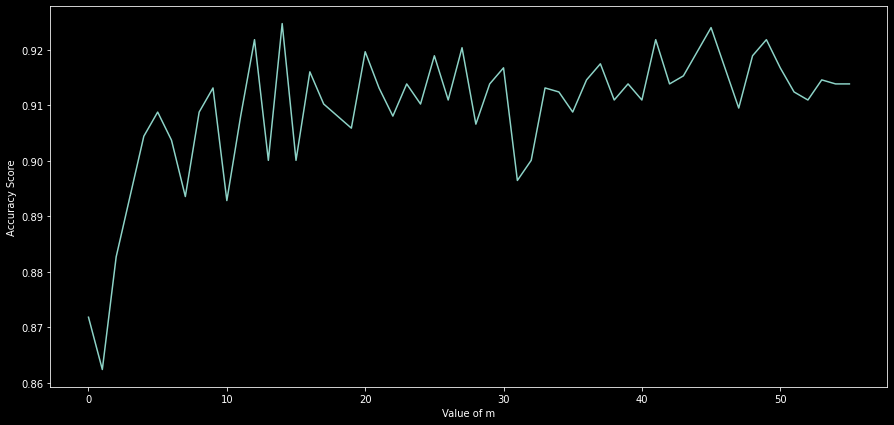

In [9]:
y = accuracies
x = [i for i in range(len(y))]
plt.figure(figsize=(15,7))
plt.plot(x,y)
plt.xlabel("Value of m")
plt.ylabel("Accuracy Score")
plt.show()

### The graph above shows the senstivity of Random Forest with various value of m.

# Part (c)

In [10]:
class DecisionTree:
    def __init__(self):
        self.tree = {}
        self.max_depth = 5

    def learn(self, training_set, target, max_features):
        total_features = len(training_set[0])
        not_included = random.sample(range(1, total_features), max_features)
        used_feature = [int(i) for i in range(total_features) if i not in not_included]
        
        self.tree = self.build_tree(training_set, target, used_feature, depth=0)

    def build_tree(self, training_set, target, used_feature, depth):
        if len(training_set) == 0:
            return 0
            
        if len(set(target)) == 1:
            return target[0]

        if (
            (training_set == training_set[0]).all()
            or len(used_feature) == len(training_set[0])
            or depth > self.max_depth
        ):
            return self.majority_class(target)

        feature_to_split, value_to_split = self.split_feature(
            training_set, target, used_feature
        )

        left_x, right_x, left_y, right_y = self.split(
            training_set, target, feature_to_split, value_to_split
        )

        tree = {}
        tree[str(feature_to_split)] = [
            value_to_split,
            self.build_tree(left_x, left_y, used_feature, depth + 1),
            self.build_tree(right_x, right_y, used_feature, depth + 1),
        ]

        return tree

    def majority_class(self, target):
        counts = np.bincount(target)
        if counts[0] > counts[1]:
            return 0
        else:
            return 1

    def split_feature(self, training_set, target, used_feature):
        info_gain = -1
        feature = -1
        value = -1

        for idx in range(len(training_set[0])):
            if idx in used_feature:
                continue

            split_points = self.get_threshold(training_set[:, idx], target)
            for point in split_points:
                left, right = self.divide(training_set[:, idx], target, point)
                divided_target = []
                divided_target.append(left)
                divided_target.append(right)
                gain = self.information_gain(target, divided_target)
                if gain > info_gain:
                    feature = idx
                    value = point
                    info_gain = gain

        used_feature.append(feature)
        return feature, value

    def get_threshold(self, training_set, target):
        thresholds = []
        for i in range(len(training_set) - 1):
            if target[i] != target[i + 1]:
                thresholds.append((training_set[i] + training_set[i + 1]) / 2)
        thresholds.sort()
        return thresholds

    def divide(self, training_set, target, point):
        left = []
        right = []
        for i in range(len(training_set)):
            if training_set[i] < point:
                left.append(target[i])
            else:
                right.append(target[i])
        return left, right

    def information_gain(self, target, divided_target):
        parent_entropy = self.entropy(target)
        current_entropy = (
            float(len(divided_target[0]))
            / len(target)
            * self.entropy(divided_target[0])
        ) + (
            float(len(divided_target[1]))
            / len(target)
            * self.entropy(divided_target[1])
        )
        return parent_entropy - current_entropy

    def entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        entropy = 0
        for prob in probabilities:
            if prob > 0:
                entropy += prob * math.log(prob, 2)
        return -entropy

    def split(self, training_set, target, feature_to_split, value_to_split):
        feature = training_set[:, feature_to_split]
        left_x = []
        right_x = []
        left_y = []
        right_y = []

        for idx in range(len(feature)):
            if feature[idx] < value_to_split:
                left_x.append(training_set[idx])
                left_y.append(target[idx])
            else:
                right_x.append(training_set[idx])
                right_y.append(target[idx])
        left_x = np.array(left_x, dtype=float)
        right_x = np.array(right_x, dtype=float)
        left_y = np.array(left_y, dtype=int)
        right_y = np.array(right_y, dtype=int)

        return left_x, right_x, left_y, right_y

    def classify(self, test_instance):
        result = self.tree
        while type(result) == dict:
            feature = list(result.keys())[0]
            if float(test_instance[int(feature)]) < result[feature][0]:
                result = result[feature][1]
            else:
                result = result[feature][2]
        return int(result)

In [11]:
class RandomForest:
    def __init__(self):
        self.decision_trees = []

    def oob_subsample(self, x_data, y_data, size):
        sampled_idx = random.sample(range(1, len(x_data)), round(len(x_data) * size))
        sample_x = []
        sample_y = []
        oob_x = []
        oob_y = []
        
        for idx in range(len(x_data)):
            if idx in sampled_idx:
                sample_x.append(x_data[idx])
                sample_y.append(y_data[idx])
            else:
                oob_x.append(x_data[idx])
                oob_y.append(y_data[idx])    
        return np.array(x_data), np.array(y_data).astype(int), np.array(oob_x), np.array(oob_y).astype(int)

    def predict(self, decision_trees, instance):
        predictions = []
        for tree in decision_trees:
            predictions.append(tree.classify(instance))
        return max(set(predictions), key=predictions.count)

    def build(self, x_train, y_train, sample_size, n_trees, max_features):
        oob = []
        for i in range(n_trees):
            x_sampled_data, y_sampled_data, x_oob, y_oob = self.oob_subsample(x_train, y_train, sample_size)
            tree = DecisionTree()
            tree.learn(x_sampled_data, y_sampled_data, max_features)
            self.decision_trees.append(tree)
            preds = [tree.classify(row) for row in x_oob]
            oob_accuracy = accuracy_score(y_oob, preds)
            oob.append(oob_accuracy)
        return np.mean(oob)

    def classify(self, x_test):
        predictions = [self.predict(self.decision_trees, row) for row in x_test]
        return predictions

In [12]:
data = np.loadtxt("spam.data")
y = data[:, -1].astype(int)
x = data[:, :-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [13]:
oob_errors = []
test_errors = []

for i in range(1, len(x_train[0]), 10):
    forest = RandomForest()
    oob_accuracy = forest.build(x_train, y_train, 0.7, 5, i)
    classification = forest.classify(x_test)
    test_accuracy = accuracy_score(y_test, classification)

    oob_errors.append(1-oob_accuracy)
    test_errors.append(1-test_accuracy)

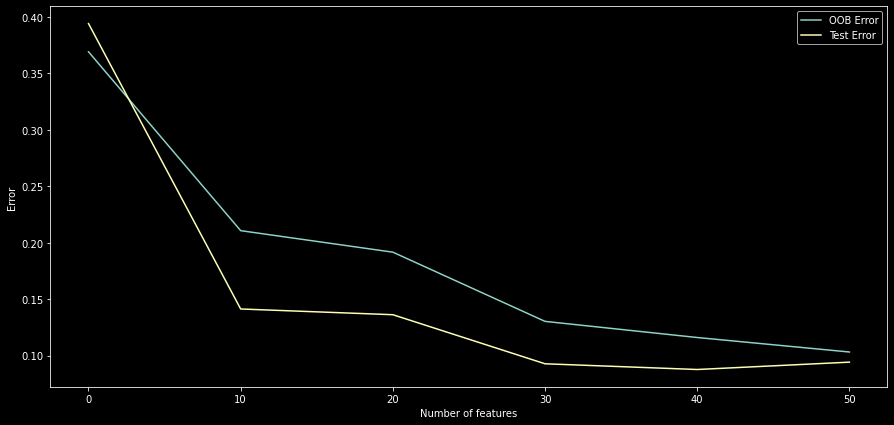

In [14]:
x = [int(i*10) for i in range(len(oob_errors))]

plt.figure(figsize=(15,7))
plt.plot(x, oob_errors, label = "OOB Error")
plt.plot(x, test_errors, label = "Test Error")

plt.xlabel("Number of features" )
plt.ylabel("Error")
plt.legend()
plt.show()